# Aims & Objectives

Goal is to predict the 'rainfall' target feature values (binary: 0 = no rain, 1 = rain) for each day of the year and maximize AUC-ROC by selecting meaningful features, experimenting with different classification models, and fine-tuning hyperparameters to improve predictive performance.

In this notebook, I will:

- Perform Exploratory Data Analysis (EDA) 📊 – Analyze trends, visualize distributions, and handle missing values.
- Build and Compare Machine Learning Models 🤖 – Train and evaluate different classification models for rainfall prediction.
- Optimize Hyperparameters ⚙️ – Fine-tune models for improved accuracy.
- Generate and Submit Predictions 📤 – Submit our best model’s probability predictions to Kaggle.

Dataset Description: 
The dataset used in this competition has been synthetically generated from a deep learning model trained on the Rainfall Prediction using Machine Learning dataset.

Evaluation Metric – AUC-ROC

AUC (Area Under the Curve), genarally between (0.5 - 1)
- Measures how well a model differentiates between positive and negative classes.
- The AUC score is computed by summing up the contributions of each segment in the ROC Curve.
- A higher AUC indicates a better model.

- AUC = 1.0 → Perfect classification.
- AUC > 0.90 → Excellent model.
- AUC = 0.50 → Random guessing.
- AUC < 0.50 → Worse than random.

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, LSTM, Input, RNN , GRU
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

- pandas and numpy: For data manipulation and numerical operations.
- matplotlib.pyplot and seaborn: For data visualization.
- sklearn.impute.SimpleImputer: For handling missing values.
- tensorflow.keras: For building and training neural network models.
- warnings: To suppress warnings.

# Loading and preprocessing Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()


# Data cleaning

In [4]:
train.drop(['id'], axis=1, inplace=True)
id_test = test['id']
test.drop(['id'], axis=1, inplace=True)

In [5]:
imp_mean = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
test[['winddirection']] = imp_mean.fit_transform(test[['winddirection']])

In [6]:
train 

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1


- Loading Data: Reading training and test datasets.
- Dropping 'id' Column: Removing the 'id' column as it is not needed for modeling.
- Handling Missing Values: Using SimpleImputer to fill missing values in the 'winddirection' column with the most frequent value

# Numerical Feature Analysis

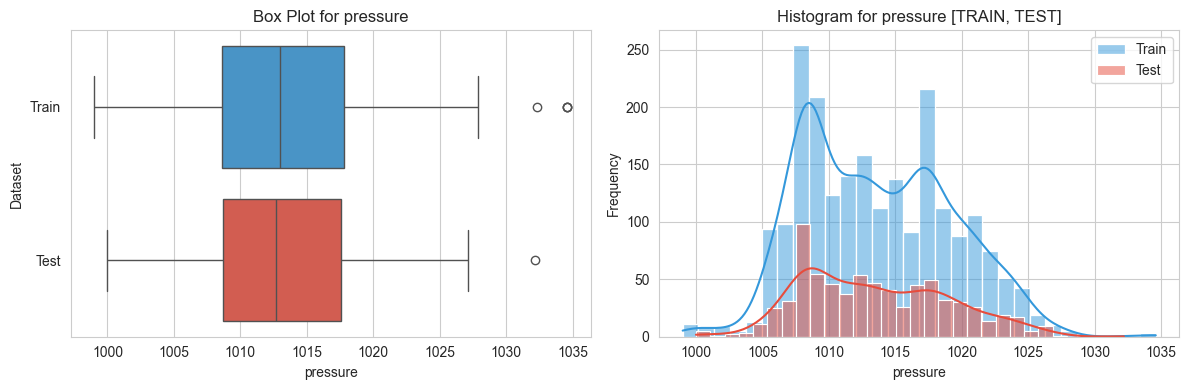

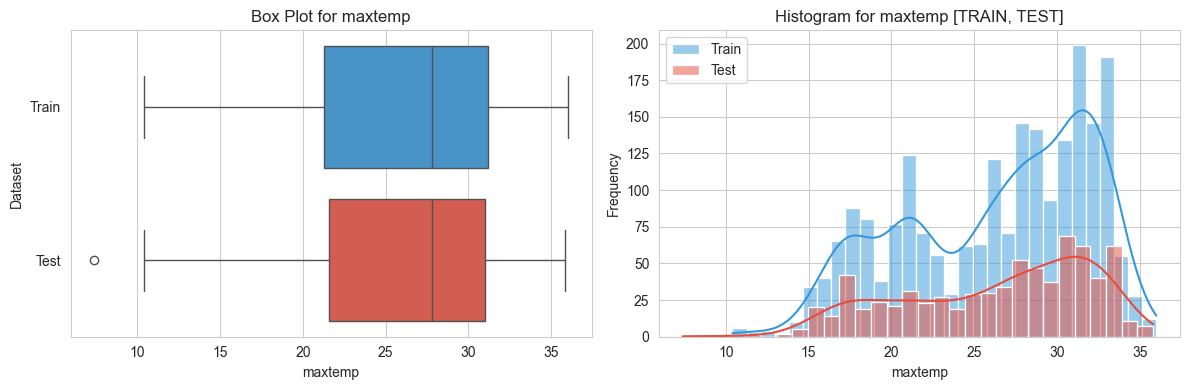

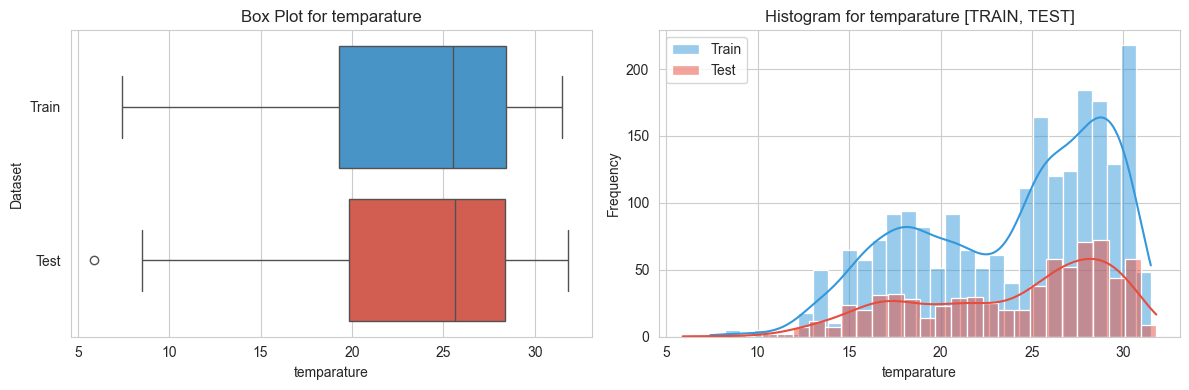

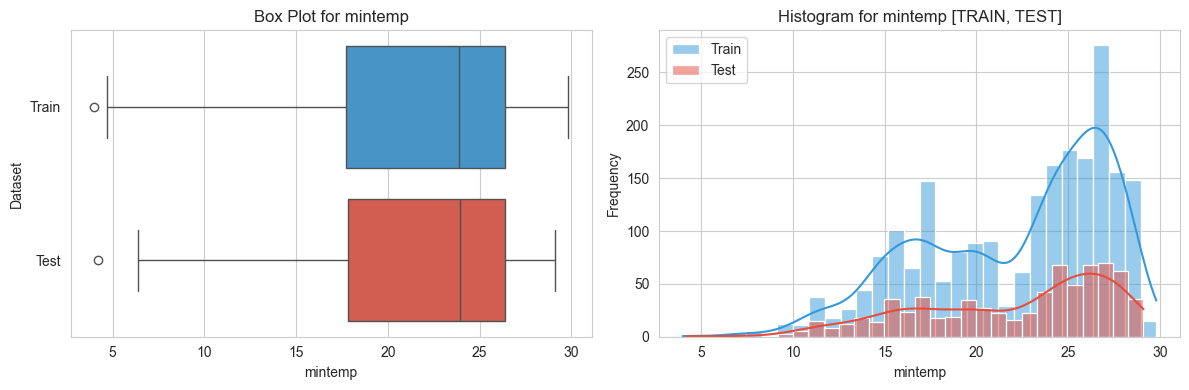

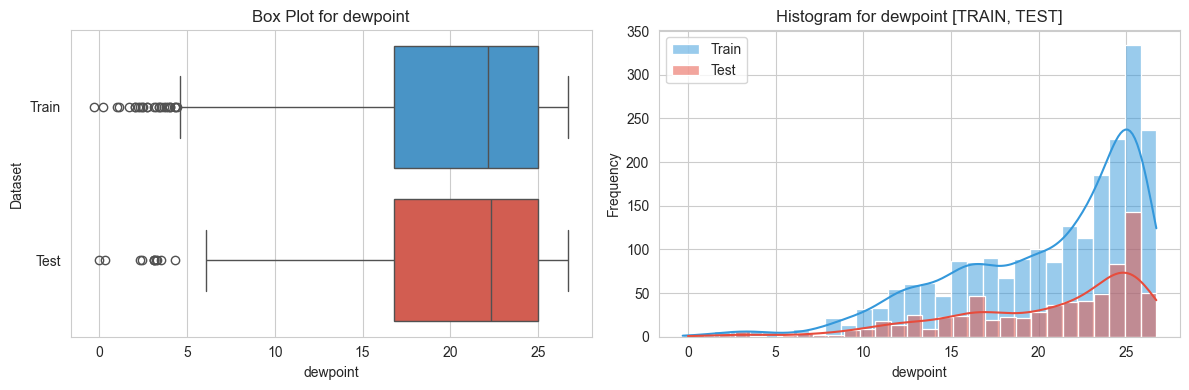

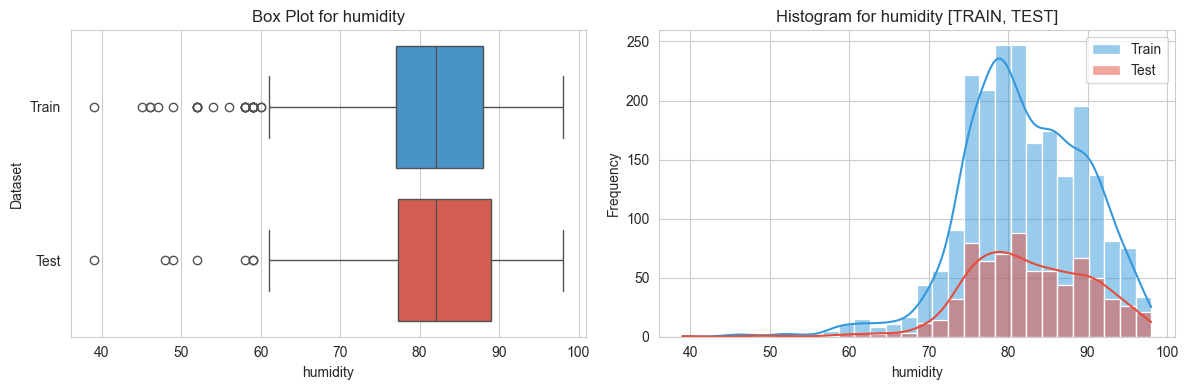

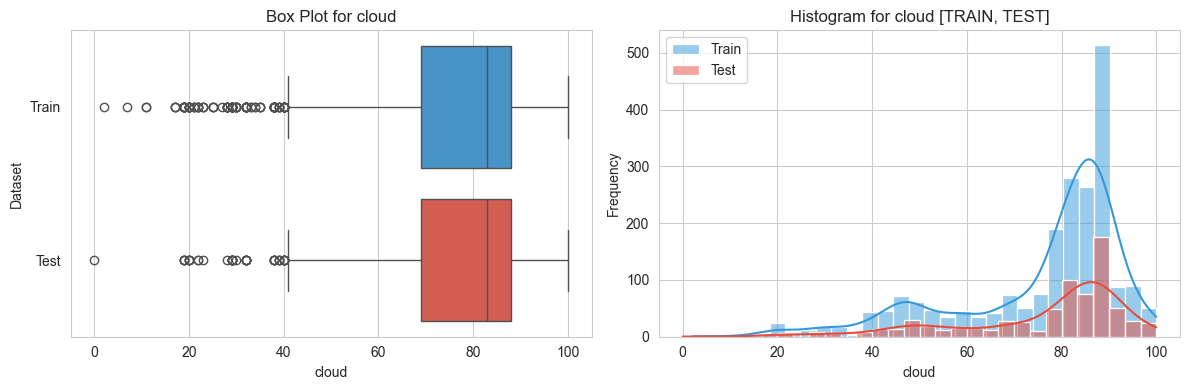

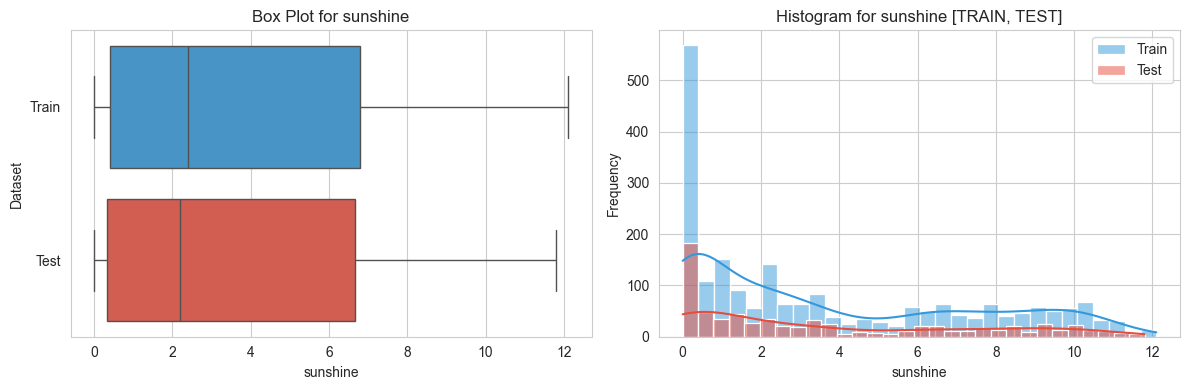

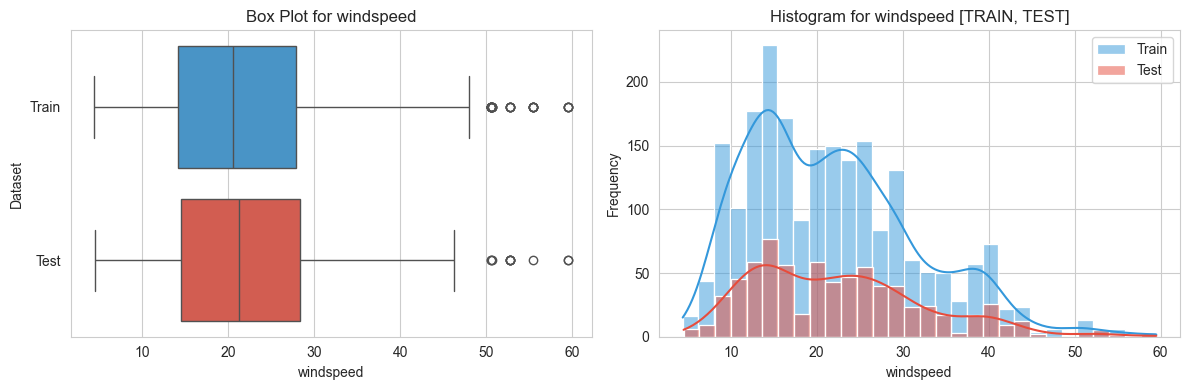

In [7]:
# Analysis of all NUMERICAL features
numerical_variables = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
target_variable = 'rainfall' 
categorical_variables = ['winddirection']

# Define a custom color palette
custom_palette = ['#3498db', '#e74c3c','#2ecc71']

# Add 'Dataset' column to distinguish between train and test data
train['Dataset'] = 'Train'
test['Dataset'] = 'Test'

# Function to create and display a row of plots for a single variable
def create_variable_plots(variable):
    sns.set_style('whitegrid')
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=pd.concat([train, test]), x=variable, y="Dataset", palette=custom_palette)
    plt.xlabel(variable)
    plt.title(f"Box Plot for {variable}")

    # Separate Histograms
    plt.subplot(1, 2, 2)
    sns.histplot(data=train, x=variable, color=custom_palette[0], kde=True, bins=30, label="Train")
    sns.histplot(data=test, x=variable, color=custom_palette[1], kde=True, bins=30, label="Test")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title(f"Histogram for {variable} [TRAIN, TEST]")
    plt.legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Perform univariate analysis for each variable
for variable in numerical_variables:
    create_variable_plots(variable)

# Drop the 'Dataset' column after analysis
train.drop('Dataset', axis=1, inplace=True)
test.drop('Dataset', axis=1, inplace=True)

- Defining Variables: Lists of numerical and categorical variables.
- Custom Palette: Defining a custom color palette for plots.
- Adding 'Dataset' Column: Adding a column to distinguish between train and test data.
- Plotting Function: Creating box plots and histograms for each numerical variable to visualize their distributions.
- Dropping 'Dataset' Column: Removing the 'Dataset' column after analysis.

Feature Engineering


In [45]:
'''
def engineer_features(df):
    """
    Create new features based on meteorological understanding and data analysis,
    with 'day' representing day of the year (1-365).
    Ensures no data leakage by avoiding use of the target variable (rainfall).
    """
    # Make a copy to avoid modifying the original dataframe
    enhanced_df = df.copy()
    
    # 1. Temperature range (difference between max and min temperatures)
    enhanced_df['temp_range'] = enhanced_df['maxtemp'] - enhanced_df['mintemp']
    
    # 2. Dew point depression (difference between temperature and dew point)
    enhanced_df['dewpoint_depression'] = enhanced_df['temparature'] - enhanced_df['dewpoint']
    
    # 3. Pressure change from previous day
    enhanced_df['pressure_change'] = enhanced_df['pressure'].diff().fillna(0)
    
    # 4. Humidity to dew point ratio
    enhanced_df['humidity_dewpoint_ratio'] = enhanced_df['humidity'] / enhanced_df['dewpoint'].clip(lower=0.1)
    
    # 5. Cloud coverage to sunshine ratio (inverse relationship)
    enhanced_df['cloud_sunshine_ratio'] = enhanced_df['cloud'] / enhanced_df['sunshine'].clip(lower=0.1)
    
    # 6. Wind intensity factor (combination of speed and humidity)
    enhanced_df['wind_humidity_factor'] = enhanced_df['windspeed'] * (enhanced_df['humidity'] / 100)
    
    # 7. Temperature-humidity index (simple version of heat index)
    enhanced_df['temp_humidity_index'] = (0.8 * enhanced_df['temparature']) + \
                                        ((enhanced_df['humidity'] / 100) * \
                                        (enhanced_df['temparature'] - 14.3)) + 46.4
    
    # 8. Pressure change rate (acceleration)
    enhanced_df['pressure_acceleration'] = enhanced_df['pressure_change'].diff().fillna(0)
    
    # 9. Seasonal features (based on day of year)
    # Convert day to month (1-365 to 1-12)
    enhanced_df['month'] = ((enhanced_df['day'] - 1) // 30) + 1
    enhanced_df['month'] = enhanced_df['month'].clip(upper=12)  # Ensure month doesn't exceed 12
    
    # 10. Convert day to season (1-365 to 1-4)
    enhanced_df['season'] = ((enhanced_df['month'] - 1) // 3) + 1
    
    # 11. Sine and cosine transformations to capture cyclical nature of days in a year
    enhanced_df['day_of_year_sin'] = np.sin(2 * np.pi * enhanced_df['day'] / 365)
    enhanced_df['day_of_year_cos'] = np.cos(2 * np.pi * enhanced_df['day'] / 365)
    
    # 12. Rolling averages for key meteorological variables
    for window in [3, 7, 14]:
        enhanced_df[f'temperature_rolling_{window}d'] = enhanced_df['temparature'].rolling(window=window, min_periods=1).mean()
        enhanced_df[f'pressure_rolling_{window}d'] = enhanced_df['pressure'].rolling(window=window, min_periods=1).mean()
        enhanced_df[f'humidity_rolling_{window}d'] = enhanced_df['humidity'].rolling(window=window, min_periods=1).mean()
        enhanced_df[f'cloud_rolling_{window}d'] = enhanced_df['cloud'].rolling(window=window, min_periods=1).mean()
        enhanced_df[f'windspeed_rolling_{window}d'] = enhanced_df['windspeed'].rolling(window=window, min_periods=1).mean()
    
    # 13. Weather pattern change features
    # Temperature trend
    enhanced_df['temp_trend_3d'] = enhanced_df['temparature'].diff(3).fillna(0)
    # Pressure trend
    enhanced_df['pressure_trend_3d'] = enhanced_df['pressure'].diff(3).fillna(0)
    # Humidity trend
    enhanced_df['humidity_trend_3d'] = enhanced_df['humidity'].diff(3).fillna(0)
    
    # 14. Extreme weather indicators
    enhanced_df['extreme_temp'] = (enhanced_df['temparature'] > enhanced_df['temparature'].quantile(0.95)) | \
                                 (enhanced_df['temparature'] < enhanced_df['temparature'].quantile(0.05))
    enhanced_df['extreme_temp'] = enhanced_df['extreme_temp'].astype(int)
    
    enhanced_df['extreme_humidity'] = (enhanced_df['humidity'] > enhanced_df['humidity'].quantile(0.95)) | \
                                     (enhanced_df['humidity'] < enhanced_df['humidity'].quantile(0.05))
    enhanced_df['extreme_humidity'] = enhanced_df['extreme_humidity'].astype(int)
    
    enhanced_df['extreme_pressure'] = (enhanced_df['pressure'] > enhanced_df['pressure'].quantile(0.95)) | \
                                     (enhanced_df['pressure'] < enhanced_df['pressure'].quantile(0.05))
    enhanced_df['extreme_pressure'] = enhanced_df['extreme_pressure'].astype(int)
    
    # 15. Interaction terms between key variables
    enhanced_df['temp_humidity_interaction'] = enhanced_df['temparature'] * enhanced_df['humidity']
    enhanced_df['pressure_wind_interaction'] = enhanced_df['pressure'] * enhanced_df['windspeed']
    enhanced_df['cloud_sunshine_interaction'] = enhanced_df['cloud'] * enhanced_df['sunshine']
    enhanced_df['dewpoint_humidity_interaction'] = enhanced_df['dewpoint'] * enhanced_df['humidity']
    
    # 16. Moving standard deviations for measuring variability
    for window in [7, 14]:
        enhanced_df[f'temp_std_{window}d'] = enhanced_df['temparature'].rolling(window=window, min_periods=4).std().fillna(0)
        enhanced_df[f'pressure_std_{window}d'] = enhanced_df['pressure'].rolling(window=window, min_periods=4).std().fillna(0)
        enhanced_df[f'humidity_std_{window}d'] = enhanced_df['humidity'].rolling(window=window, min_periods=4).std().fillna(0)
    
    return enhanced_df
    
train_fe=engineer_features(train)
test_fe=engineer_features(test)'
'''

'\ndef engineer_features(df):\n    """\n    Create new features based on meteorological understanding and data analysis,\n    with \'day\' representing day of the year (1-365).\n    Ensures no data leakage by avoiding use of the target variable (rainfall).\n    """\n    # Make a copy to avoid modifying the original dataframe\n    enhanced_df = df.copy()\n    \n    # 1. Temperature range (difference between max and min temperatures)\n    enhanced_df[\'temp_range\'] = enhanced_df[\'maxtemp\'] - enhanced_df[\'mintemp\']\n    \n    # 2. Dew point depression (difference between temperature and dew point)\n    enhanced_df[\'dewpoint_depression\'] = enhanced_df[\'temparature\'] - enhanced_df[\'dewpoint\']\n    \n    # 3. Pressure change from previous day\n    enhanced_df[\'pressure_change\'] = enhanced_df[\'pressure\'].diff().fillna(0)\n    \n    # 4. Humidity to dew point ratio\n    enhanced_df[\'humidity_dewpoint_ratio\'] = enhanced_df[\'humidity\'] / enhanced_df[\'dewpoint\'].clip(lower=0.

# Data Scaling and Splitting


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X = train.drop('rainfall',axis=1)
y = train['rainfall']

#scaler = MinMaxScaler()
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2, random_state=100)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

- Scaling: Standardizing the features using StandardScaler.
- Splitting: Splitting the data into training and testing sets.

# Model Training and Hyperparameter Optimization

In [ ]:
import optuna
from optuna.integration import TFKerasPruningCallback


def objective(trial):
    # Define the model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(GRU(trial.suggest_int('units_lstm', 100, 256 ), activation='tanh', return_sequences=False))
    model.add(Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5)))
    model.add(Dense(trial.suggest_int('units_dense', 32, 128), activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(trial.suggest_float('dropout_rate_1', 0.2, 0.5)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=200,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')],
        batch_size=32,
        verbose=0
    )

    # Get the best validation AUC score
    best_score = max(history.history['val_AUC'])
    return best_score

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)



[I 2025-03-11 23:08:09,115] A new study created in memory with name: no-name-4a07f2a1-cf49-4ed9-b28c-17e1f367bff8
[I 2025-03-11 23:08:16,342] Trial 0 finished with value: 0.9007370471954346 and parameters: {'units_lstm': 178, 'dropout_rate': 0.4029034286746803, 'units_dense': 75, 'dropout_rate_1': 0.230585380808803}. Best is trial 0 with value: 0.9007370471954346.
[I 2025-03-11 23:08:25,633] Trial 1 finished with value: 0.9025506973266602 and parameters: {'units_lstm': 239, 'dropout_rate': 0.2947112144604093, 'units_dense': 35, 'dropout_rate_1': 0.22237481149157234}. Best is trial 1 with value: 0.9025506973266602.
[I 2025-03-11 23:08:36,563] Trial 2 finished with value: 0.9033855199813843 and parameters: {'units_lstm': 244, 'dropout_rate': 0.4998414421628804, 'units_dense': 113, 'dropout_rate_1': 0.42625358911913835}. Best is trial 2 with value: 0.9033855199813843.
[I 2025-03-11 23:08:43,973] Trial 3 finished with value: 0.9000604152679443 and parameters: {'units_lstm': 137, 'dropout_r

KeyboardInterrupt: 

- Optuna: Using Optuna for hyperparameter optimization.
- Objective Function: Defining the model and training process, including hyperparameter suggestions.
- Study: Creating and optimizing the study to find the best hyperparameters.

# K-Fold Cross-Validation


In [62]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Definiujemy liczbę podziałów dla KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

# Reset indices of X_train and y_train
X_train_reset = X_train.reshape(X_train.shape[0], X_train.shape[1]).copy()
y_train_reset = y_train.reset_index(drop=True)

for train_index, val_index in kf.split(X_train_reset):
    X_tr, X_val = X_train_reset[train_index], X_train_reset[val_index]
    y_tr, y_val = y_train_reset[train_index], y_train_reset[val_index]
    
    # Tworzymy nowy model dla każdej iteracji
    model = Sequential()
    model.add(Input(shape=(X_tr.shape[1], 1)))
    model.add(GRU(best_params['units_lstm'], activation='tanh', return_sequences=False))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(best_params['units_dense'], activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(best_params['dropout_rate_1']))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    
    # Trening modelu
    history = model.fit(
        X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1), y_tr,
        epochs=200,
        validation_data=(X_val.reshape(X_val.shape[0], X_val.shape[1], 1), y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        batch_size=32,
        verbose=0
    )
    
    # Obliczamy AUC na zbiorze walidacyjnym
    y_val_pred = model.predict(X_val.reshape(X_val.shape[0], X_val.shape[1], 1)).ravel()
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    print(f'Fold AUC: {auc}')

# Średnia wartość AUC
mean_auc = np.mean(auc_scores)
print(f'Mean AUC from K-Fold: {mean_auc}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Fold AUC: 0.8636992619926199
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold AUC: 0.8981205130273452
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold AUC: 0.8838928856914469
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold AUC: 0.8732233017947304
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold AUC: 0.9076160990712074
Mean AUC from K-Fold: 0.8853104123154699


- K-Fold Cross-Validation: Evaluating the model using 5-fold cross-validation to ensure robustness.
- AUC Calculation: Calculating the AUC score for each fold and computing the mean AUC

# Final Model Training and Prediction

In [ ]:
print('Best hyperparameters: ', study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
best_model = Sequential()
best_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(GRU(best_params['units_lstm'], activation='tanh', return_sequences=False))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Dense(best_params['units_dense'], activation='relu', kernel_initializer='he_normal'))
best_model.add(Dropout(best_params['dropout_rate_1']))
best_model.add(Dense(1, activation='sigmoid'))

best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Train the final model on the entire training data
history = best_model.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
    batch_size=32
)

# Get the best validation AUC score
best_score = max(history.history['val_AUC'])
print('Best score: ', best_score)

Best hyperparameters:  {'units_lstm': 244, 'dropout_rate': 0.4998414421628804, 'units_dense': 113, 'dropout_rate_1': 0.42625358911913835}
Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.5502 - loss: 0.6020 - val_AUC: 0.8581 - val_loss: 0.3844
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8560 - loss: 0.3892 - val_AUC: 0.8865 - val_loss: 0.3461
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8720 - loss: 0.3691 - val_AUC: 0.8870 - val_loss: 0.3479
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8567 - loss: 0.3806 - val_AUC: 0.8922 - val_loss: 0.3383
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8814 - loss: 0.3577 - val_AUC: 0.8821 - val_loss: 0.3669
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8782 - loss: 0.3626 - val_AUC: 0.8966 - val_loss: 0.3355
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8558 - loss: 0.3782 - val_AUC: 0.8952 - val_loss: 0.3315
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7

KeyboardInterrupt: 

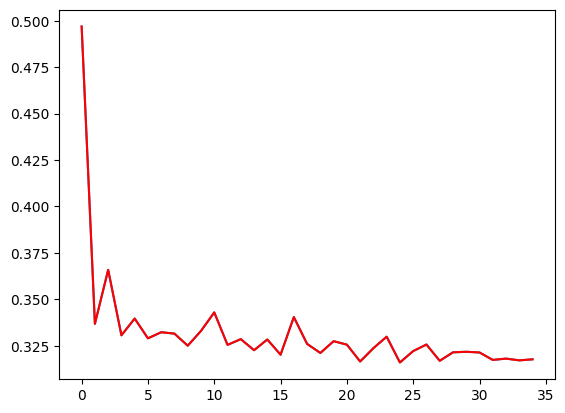

In [ ]:
val_loss = history.history['val_loss']
val_loss_2 = history.history['val_loss']

plt.plot(val_loss, label='Model 1')
plt.plot(val_loss_2, label='Model 2' , color='red')

In [ ]:
# Reshape the test data
test_reshaped = scaler.transform(test)
test_reshaped = test_reshaped.reshape((test_reshaped.shape[0], test_reshaped.shape[1], 1))

# Make predictions on the reshaped test data
submission = pd.DataFrame()
submission['id'] = id_test  
submission['rainfall'] = best_model.predict(test_reshaped)
submission.to_csv('submission.csv', index=False)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
submission

,id,rainfall
0,2190,0.964801
1,2191,0.990111
2,2192,0.898722
3,2193,0.072807
4,2194,0.029076
...,...,...
725,2915,0.987131
726,2916,0.853867
727,2917,0.957358
728,2918,0.992641


- Final Model Training: Training the final model with the best hyperparameters on the entire training data.
- Prediction: Making predictions on the test data and saving the results to a CSV file.